In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward
import mplhep as hep
hep.set_style(hep.style.CMS)

/tmp/ipykernel_3486479/915909902.py:7: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.CMS)


In [2]:
class RootTreeReader:

    """ 
    Read data from a ROOT TTree 
    Parameters:
    path : string
        Path to the ROOT file
    tree_name : string (default=Delphes)
        Name of the ROOT TTree
    Attributes:
    tree: Root TTree 
    """

    def __init__(self, path: str, tree_name: str = "Delphes"):
        self.tree = uproot.open(path)[tree_name]


    def get_branches(self, branches = ["MissingET.MET",
                                       "MissingET.Eta",
                                       "MissingET.Phi",
                                       "Jet.PT",
                                       "Jet.Eta",
                                       "Jet.Phi",
                                       "Jet.Mass",
                                       "Jet.TauTag",
                                       "Jet.BTag",
                                       "Jet_size"], max_elements=4):
        """
        returns a DataFrame with branches as features
        branches : array-like
          branches to load from the ROOT tree
        max_elements : int (default=4)
          maximum number of elements to load from jagged arrays
        """   
        self._max_elements = max_elements
        self._df = pd.DataFrame(index=range(self.tree.num_entries))

        for branch in branches:
          self._join_branch(branch)

        return self._set_columns_names(self._df)


    def _join_branch(self, branch):
        """joins a branch to self._df"""
        df = self.tree.arrays(branch, library="pd")

        if "." in branch:
            if len(df) > len(df.groupby(level=0).size()):
                self._add_jagged_branch(df, branch)
            else:
                self._add_branch(df, branch)
        else:
            self._add_branch(df, branch)


    def _add_branch(self, df, branch: str):
        """adds a non-jagged branch to self.df"""
        self._df[branch] = self.tree[branch].array(library="pd").values


    def _add_jagged_branch(self, df, branch):
        """adds a jagged branch to self.df"""
        df = df.unstack().iloc[:,:self._max_elements]
        df.columns = ["{0}{1}".format(branch, i) for i in range(self._max_elements)]
        self._df = self._df.join(df)

    @staticmethod
    def _set_columns_names(df):
        df.columns = df.columns.str.lower().str.replace(".","_")
        return df


def build_df(path):
    """
    Generates a Dataframe from the root in "path"
    """
    reader = RootTreeReader(path)
    df = reader.get_branches()
    df["n_b"]  =  reader.tree.arrays("Jet.BTag", library="pd").sum(level=0)
    df["n_tau"] = reader.tree.arrays("Jet.TauTag", library="pd").sum(level=0)
    return df

In [135]:
# Cut for events with at least 1 tau
def tau_cut(df, val = 0):
  mask = (df.n_tau > val) & (df.jet_tau_index >= 0)
  return df.loc[mask]

def b_cut(df, val = 0):
  mask = (df.n_b > val) & (df.jet_b_index >= 0)
  return df.loc[mask]


#Cuts over the final Df

def pt_tau_cut(df, val = 25):
  # leading jets pt > 30 GeV
  mask = df.tau_pT > val
  return df.loc[mask]


def pt_b_cut(df, val = 30):
  # leading jets pt > 30 GeV
  mask = df.b_pT > val
  return df.loc[mask]


def eta_tau_cut(df, val = 2.4):
  # leading jets eta < 2.4
  mask = np.abs(df.tau_eta) < val
  return df.loc[mask]


def eta_b_cut(df, val = 2.1):
  # leading jets eta < 2.4
  mask = np.abs(df.b_eta) < val
  return df.loc[mask]


def phi_tau_cut(df, val= 2.0):
  # delta phi between met and tau > 2.0
  mask = np.abs(df.Delta_phi_Tau_Met) > val
  return df.loc[mask]


def et_met_cut(df, val = 200):
  # Met et greater than 200
  mask = df.met_Met > val
  return df.loc[mask]


def final_cuts(df, pt_tau = 25, pt_b = 30, eta_tau = 2.4, eta_b = 2.4, met = 150, del_phi = 1.0):
  cut_df = df.copy()
  cut_df = pt_tau_cut(cut_df, pt_tau)
  cut_df = pt_b_cut(cut_df, pt_b)
  cut_df = eta_tau_cut(cut_df, eta_tau)
  cut_df = phi_tau_cut(cut_df, del_phi)
  cut_df = eta_b_cut(cut_df, eta_b)
  cut_df = et_met_cut(cut_df, met)
  return cut_df


def branch_index(df, branch):
  """
  Adds a column with the index of the first jet tagged as branch to the df.

  Branch:
    takes values of "jet_btag" or "jet_tautag"
  
  Ex:
    branch_index(cut_df, "jet_tautag")
    Returns a df with a column with the first jet tagged as tau per ivent
  """
  branch_jets = df[["{0}{1}".format(branch,i) for i in range(4)]].copy()

  # events with branch jets
  branch_events = branch_jets[branch_jets.sum(axis=1) > 0]

  # index of first branch jet
  branch_index = branch_events.apply(lambda x: x > 0).apply(lambda x: np.nonzero(x.values)[0][0], axis=1)

  # index of non branch jets (set to nan)
  branch_nan = pd.DataFrame(index= branch_jets[branch_jets.sum(axis=1) == 0].index)

  # branch jet index
  df["{}_index".format(branch).replace('tag','')] = pd.concat([branch_index,branch_nan]).sort_index()

  return df , branch_index


def DeltaPhi(row, col1 = 'tau_phi', col2 = 'met_Phi'):
  """
  correction on azimuthal angle difference dphi
  """
  dphi = row[col1] - row[col2]
  if dphi >= np.pi: 
     dphi -= 2*np.pi
  if dphi < -np.pi:
    dphi += 2*np.pi

  return dphi


def DeltaPhi2(dphi):
  """
  correction on azimuthal angle difference dphi
  """
  dphi = phi1 - phi2
  if dphi >= np.pi: 
     dphi -= 2*np.pi
  if dphi < -np.pi:
    dphi += 2*np.pi


def m_Tot(row):  
  #Calculates TotalMass from 5.4  https://arxiv.org/pdf/1709.07242.pdf   
  pt1 = row['tau_pT']
  px1 = row['tau_pT'] * np.cos(row['tau_phi'])
  py1 = row['tau_pT'] * np.sin(row['tau_phi'])
  pt2 = row['b_pT']
  px2 = row['b_pT'] * np.cos(row['b_phi'])
  py2 = row['b_pT'] * np.sin(row['b_phi'])
  met_pt3 = row['met_Met']
  px3 = met_pt3 * np.cos(row['met_Phi'])
  py3 = met_pt3 * np.sin(row['met_Phi'])

  
  vec1 = np.array([px1 , py1])
  vec2 = np.array([px2 , py2])
  vec3 = np.array([px3 , py3])
  vect_t = vec1 + vec2 + vec3 
  vec_t2 = np.dot(vect_t, vect_t)
  sum_escal = (pt1 + pt2 + met_pt3) **2
  return (sum_escal - vec_t2  ) ** 0.5


def transverse_mass(tau_pt, met_et, deltaphi):
  #Calculates the transverse mass between tau (or any other jet) and the met
  return np.sqrt(2 * tau_pt * met_et * (1 - np.cos(deltaphi)))

def invariant_mass(obj1_pt, obj1_eta, obj2_pt, obj2_eta, deltaphi ):
  #Calculates the invariant mass for 2 different objects
  return np.sqrt(2 * obj1_pt * obj2_pt * (np.cosh(obj1_eta-obj2_eta) - np.cos(deltaphi)))

def Get_Pt_Eta_Phi_Tau_B(row):
  """
  Returns a row with a list of the Pt, Eta, Phi
  of the Taus and B's (in the respective order)
  Needs a column named Tau_b_Tuple.
  """
  n_tau = int(row['jet_tau_index'])
  n_b = int(row['jet_b_index'])

  s = pd.Series(cols)
  s1 = list(s[s.astype(str).str[-1] == str(n_tau)][:4])
  s2 = list(s[s.astype(str).str[-1] == str(n_b)][:4])

  tau_pT = row[str(s1[0])] 
  tau_eta = row[str(s1[1])] 
  tau_phi = row[str(s1[2])] 
  tau_mass = row[str(s1[3])]

  b_pT = row[str(s2[0])] 
  b_eta = row[str(s2[1])] 
  b_phi = row[str(s2[2])] 
  b_mass = row[str(s2[3])]

  met_Met = row['missinget_met']	
  met_Phi = row['missinget_phi']	
  met_Eta = row['missinget_eta']

  return (tau_pT, tau_eta, tau_phi, tau_mass, b_pT, b_eta, b_phi, b_mass, met_Met, met_Phi, met_Eta, n_tau, n_b)


def generate_ploteable_invariant_masses(df1, df2, df3):
  #Generates a series for the transverse masses between tau and MET for each dataframe  
  m1 = invariant_mass(df1.tau_pT, df1.tau_eta, df1.b_pT, df1.b_eta, df1.Delta_phi_Tau_B )
  m2 = invariant_mass(df2.tau_pT, df2.tau_eta, df2.b_pT, df2.b_eta, df2.Delta_phi_Tau_B )
  m3 = invariant_mass(df3.tau_pT, df3.tau_eta, df3.b_pT, df3.b_eta, df3.Delta_phi_Tau_B )
  return m1, m2, m3

def generate_ploteable_tr_tau_nu_masses(df1, df2, df3):
  #Generates a series for the transverse masses between tau and MET for each dataframe  
  m1 = transverse_mass(df1.tau_pT, df1.met_Met, df1.Delta_phi_Tau_Met)
  m2 = transverse_mass(df2.tau_pT, df2.met_Met, df2.Delta_phi_Tau_Met)
  m3 = transverse_mass(df3.tau_pT, df3.met_Met, df3.Delta_phi_Tau_Met)
  return m1, m2, m3

def generate_ploteable_tr_b_nu_masses(df1, df2, df3):
  #Generates a series for the transverse masses between B and MET for each dataframe 
  m1 = transverse_mass(df1.b_pT, df1.met_Met, df1.Delta_phi_B_Met)
  m2 = transverse_mass(df2.b_pT, df2.met_Met, df2.Delta_phi_B_Met)
  m3 = transverse_mass(df3.b_pT, df3.met_Met, df3.Delta_phi_B_Met)
  return m1, m2, m3

def generate_ploteable_total_masses(df1, df2, df3):
  #Generates a series for the total msses between B , tau and MET for each dataframe  
  m1 = df1.apply(m_Tot, axis = 1)
  m2 = df2.apply(m_Tot, axis = 1)
  m3 = df3.apply(m_Tot, axis = 1)
  return m1, m2, m3


def generate_data_b_tau_nu(df):
  """Returns a Dataframe with the information per event
  of the tau_jet and the missin energy.
  The index preserves the index from the original dataframe.
  Arguments:
    df :  dataframe generated with 
    get_braches("MissingET.MET","MissingET.Eta","MissingET.Phi","Jet.PT",
                "Jet.Eta","Jet.Phi","Jet.Mass","Jet.TauTag","Jet.BTag","Jet_size")
          
    Also the dataframe must content a column named as n_tau as the number of taus per event
  Columns : 
    'tau_pT' ,'tau_eta' ,'tau_phi' ,'tau_mass', 'b_pT' ,'b_eta' ,'b_phi' ,'b_mass','met_Met' ,'met_Phi' ,'met_Eta', 'n_tau', 'n_b'.

  """
  cut_df, tau_index = branch_index(df, 'jet_tautag')
  cut_df, tau_index = branch_index(cut_df, 'jet_btag')
  cut_df = tau_cut(cut_df)
  cut_df = b_cut(cut_df)

  s = cut_df.apply(Get_Pt_Eta_Phi_Tau_B, axis = 1)
  Df = pd.DataFrame(s.to_list(), index = s.index, 
                    columns=['tau_pT' ,'tau_eta' ,'tau_phi' ,'tau_mass', 
                             'b_pT' ,'b_eta' ,'b_phi' ,'b_mass',
                             'met_Met' ,'met_Phi' ,'met_Eta' ,'n_tau', 'n_b'])
  
  Df['Delta_phi_Tau_Met'] = Df.apply(DeltaPhi,axis = 1)
  Df['Delta_phi_B_Met'] = Df.apply(DeltaPhi,axis = 1, args=('b_phi', 'met_Phi'))
  Df['Delta_phi_Tau_B'] = Df.apply(DeltaPhi,axis = 1, args=('tau_phi', 'b_phi'))
  Df = Df.copy()[Df.n_tau != Df.n_b]
  return Df

def plot_mass1(labels, colors, lines, mass_type,m1, m2 ,m3, m_bg1, m_bg2, Weights
               , nbins = [40, 40, 40] ,bins_bg = [30,10], loga = True):

  """
  Returns a figure with 3 histograms for the 3 arguments, 
  with nbins number of bins and mass_type as a string for the
  x_axis label
  """
  plt.figure(figsize=(10,7))
  plt.title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=16)

  counts_s1, binss1 = np.histogram(m1, nbins[0])
  plt.hist(binss1[:-1], bins = binss1, weights = Weights[0]*counts_s1, color= colors[0], linestyle= lines[0],
           label = labels[0], histtype="step", linewidth = "2", log = loga)
  counts_s2, binss2 = np.histogram(m2, nbins[1])
  plt.hist(binss2[:-1], bins = binss2, weights = Weights[1]*counts_s2, color= colors[1], linestyle= lines[1],
           histtype="step", linewidth = "2", label = labels[1], log = loga)
  counts_s3, binss3 = np.histogram(m3, nbins[2])
  plt.hist(binss3[:-1], bins = binss3, weights = Weights[2]*counts_s3, color= colors[2], linestyle= lines[2],
           histtype="step", linewidth = "2", label = labels[2], log = loga)
  counts_b1, binsb1 = np.histogram(m_bg1, bins_bg[0])
  plt.hist(binsb1[:-1], bins = binsb1, weights = Weights[3]*counts_b1, color= colors[3], histtype="stepfilled",
           alpha = 0.7, edgecolor='k', label = labels[3], log = loga)
  counts_b2, binsb2 = np.histogram(m_bg2, bins_bg[1])
  plt.hist(binsb2[:-1], bins = binsb2, weights = Weights[4]*counts_b2, color= colors[4], histtype="stepfilled",
           alpha = 0.7, edgecolor='k', label = labels[4], log = loga)
  
  plt.ylabel("Events", fontsize= 17)
  plt.xlabel(mass_type, fontsize= 17)
  plt.xticks(fontsize= 14)
  plt.yticks(fontsize= 14)
  plt.legend(loc ='best', fontsize= 13)
  plt.savefig("{}".format(mass_type));

#def plot_Met_ET_Phi1(MET_ET1, MET_ET2, MET_ET3, MET_Phi1, MET_Phi2, MET_Phi3, labels, colors, lines):
def plot_Met_ET_Phi1(df1, df2, df3, bg1, bg2, labels, colors, lines):

  """
  Returns a 1 dimentional array with 3 histograms in 2 axis with the information of 
  missing energy in the transverse plane and the angle phi in that plane
  """
  fig, ax = plt.subplots(1, 2, figsize = (14, 6), constrained_layout=True)
  #fig.suptitle(f'Variables del MET', fontsize = 17)
  bines1 = np.linspace(0,1500,30)
  ax[0].hist(df1.missinget_met, bins = bines1, histtype="step", density = True, linewidth = "2", 
             color= colors[0], linestyle= lines[0], label = labels[0])
  ax[0].hist(df2.missinget_met, bins = bines1, histtype="step", density = True, linewidth = "2",
             color= colors[1], linestyle= lines[1], label = labels[1])
  ax[0].hist(df3.missinget_met, bins = bines1, histtype="step", density = True, linewidth = "2", 
             color= colors[2], linestyle= lines[2], label = labels[2])
  ax[0].hist(bg1.missinget_met, bins = bines1, histtype="stepfilled", density = True, 
             color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[0].hist(bg2.missinget_met, bins = bines1,histtype="stepfilled", density = True, 
             color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')
  
  bines2 = np.linspace(-np.pi,np.pi,20)
  ax[1].hist(df1.missinget_phi, bins = bines2, histtype="step", density = True, linewidth = "2", 
             color= colors[0], linestyle= lines[0], label = labels[0])
  ax[1].hist(df2.missinget_phi, bins = bines2, histtype="step", density = True, linewidth = "2",
             color= colors[1], linestyle= lines[1], label = labels[1])
  ax[1].hist(df3.missinget_phi, bins = bines2, histtype="step", density = True, linewidth = "2", 
             color= colors[2], linestyle= lines[2], label = labels[2])
  ax[1].hist(bg1.missinget_phi, bins = bines2, histtype="stepfilled", density = True, 
             color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[1].hist(bg2.missinget_phi, bins = bines2, histtype="stepfilled", density = True, 
             color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')

  ax[0].legend(loc = 'best',fontsize= 13)
  ax[1].legend(loc = 'lower center',fontsize= 13)
  
  ax[0].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[1].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)

  ax[0].set_ylabel("a.u.", fontsize= 17)
  ax[0].set_xlabel("$MET$", fontsize= 17)
  ax[1].set_ylabel("a.u.", fontsize= 17)
  ax[1].set_xlabel(r"$\phi$", fontsize= 17)
  fig.savefig('Met_Variables')

    
    
def plot_Met_ET_Phi2(df1, df2, df3, bg1, bg2, labels, colors, lines):

  """
  Returns a 1 dimentional array with 3 histograms in 2 axis with the information of 
  missing energy in the transverse plane and the angle phi in that plane
  """
  bines1 = np.linspace(0,1500,30)
  fig, ax = plt.subplots(1, 2, figsize = (14, 6), constrained_layout=True)
  fig.suptitle('Variables del MET', fontsize = 17)
  ax[0].hist(df1.met_Met, bins = bines1, histtype="step", density = True, linewidth = "2", 
             color= colors[0], linestyle= lines[0], label = labels[0])
  ax[0].hist(df2.met_Met, bins = bines1, histtype="step", density = True, linewidth = "2",
             color= colors[1], linestyle= lines[1], label = labels[1])
  ax[0].hist(df3.met_Met, bins = bines1, histtype="step", density = True, linewidth = "2", 
             color= colors[2], linestyle= lines[2], label = labels[2])
  ax[0].hist(bg1.met_Met, bins = bines1, histtype="stepfilled", density = True, 
             color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[0].hist(bg2.met_Met, bins = bines1,histtype="stepfilled", density = True, 
             color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')


  bines2 = np.linspace(-np.pi,np.pi,20)
  ax[1].hist(df1.met_Phi, bins = bines2, histtype="step", density = True, linewidth = "2", 
             color= colors[0], linestyle= lines[0], label = labels[0])
  ax[1].hist(df2.met_Phi, bins = bines2, histtype="step", density = True, linewidth = "2",
             color= colors[1], linestyle= lines[1], label = labels[1])
  ax[1].hist(df3.met_Phi, bins = bines2, histtype="step", density = True, linewidth = "2", 
             color= colors[2], linestyle= lines[2], label = labels[2])
  ax[1].hist(bg1.met_Phi, bins = bines2, histtype="stepfilled", density = True, 
             color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[1].hist(bg2.met_Phi, bins = bines2, histtype="stepfilled", density = True, 
             color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')

  ax[0].legend(loc = 'best',fontsize= 13)
  ax[1].legend(loc = 'lower center',fontsize= 13)
  
  ax[0].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[1].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)

  ax[0].set_ylabel("a.u.", fontsize= 18)
  ax[0].set_xlabel("$MET$", fontsize= 18)
  ax[1].set_ylabel("a.u.", fontsize= 18)
  ax[1].set_xlabel(r"$\phi$", fontsize= 18)

def plot_pt_eta_phi1(labels, colors, lines, df1, df2, df3, bg1, bg2, i):
  """
  Returns a 2 dimentional array with 3 histograms in 3 axis with the information of 
  pt eta and phi for an object
  """
  bins1 = np.linspace(0,1500,30) 
  fig, ax = plt.subplots(2, 2, figsize = (14, 12), constrained_layout=True)
  fig.suptitle('Variables del jet_{}'.format(i), fontsize = 15)
  ax[0,0].hist(df1['jet_pt{}'.format(i)], bins = bins1, histtype="step", density =True, linewidth = "2", 
               color= colors[0], linestyle= lines[0], label = labels[0])
  ax[0,0].hist(df2['jet_pt{}'.format(i)], bins = bins1, histtype="step", density =True, linewidth = "2",
               color= colors[1], linestyle= lines[1], label = labels[1])
  ax[0,0].hist(df3['jet_pt{}'.format(i)], bins = bins1, histtype="step", density =True, linewidth = "2", 
               color= colors[2], linestyle= lines[2], label = labels[2])
  ax[0,0].hist(bg1['jet_pt{}'.format(i)], bins = bins1, histtype="stepfilled", density =True, 
               color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[0,0].hist(bg2['jet_pt{}'.format(i)], bins = bins1, histtype="stepfilled", density =True, 
               color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')
  
  bins2 = np.linspace(-4.5,4.5,25)
  ax[0,1].hist(df1['jet_eta{}'.format(i)], bins = bins2, histtype="step", density =True, linewidth = "2", 
               color= colors[0], linestyle= lines[0], label = labels[0])
  ax[0,1].hist(df2['jet_eta{}'.format(i)], bins = bins2, histtype="step", density =True, linewidth = "2",
               color= colors[1], linestyle= lines[1], label = labels[1])
  ax[0,1].hist(df3['jet_eta{}'.format(i)], bins = bins2, histtype="step", density =True, linewidth = "2", 
               color= colors[2], linestyle= lines[2], label = labels[2])
  ax[0,1].hist(bg1['jet_eta{}'.format(i)], bins = bins2, histtype="stepfilled", density =True, 
               color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[0,1].hist(bg2['jet_eta{}'.format(i)], bins = bins2, histtype="stepfilled", density =True, 
               color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')

  bins3 = np.linspace(-np.pi, np.pi,25)
  ax[1,0].hist(df1['jet_phi{}'.format(i)], bins = bins3, histtype="step", density =True, linewidth = "2", 
               color= colors[0], linestyle= lines[0], label = labels[0])
  ax[1,0].hist(df2['jet_phi{}'.format(i)], bins = bins3, histtype="step", density =True, linewidth = "2",
               color= colors[1], linestyle= lines[1], label = labels[1])
  ax[1,0].hist(df3['jet_phi{}'.format(i)], bins = bins3, histtype="step", density =True, linewidth = "2", 
               color= colors[2], linestyle= lines[2], label = labels[2])
  ax[1,0].hist(bg1['jet_phi{}'.format(i)], bins = bins3, histtype="stepfilled", density =True, 
               color= colors[3], label = labels[3], alpha = 0.7, edgecolor='k')
  ax[1,0].hist(bg2['jet_phi{}'.format(i)], bins = bins3, histtype="stepfilled", density =True, 
               color= colors[4], label = labels[4], alpha = 0.7, edgecolor='k')

  bins4 = np.linspace(0, np.pi,25)
  ax[1,1].hist(np.abs(df1.apply(DeltaPhi, axis = 1, args= ('jet_phi{}'.format(i), "missinget_phi"))),
               bins = bins4, histtype="step", density =True, linewidth = "2",
               color= colors[0], linestyle= lines[0], label = labels[0])
  ax[1,1].hist(np.abs(df2.apply(DeltaPhi, axis = 1, args= ('jet_phi{}'.format(i), "missinget_phi"))),
               bins = bins4, histtype="step", density =True, linewidth = "2",
               color= colors[1], linestyle= lines[1], label = labels[1])
  ax[1,1].hist(np.abs(df3.apply(DeltaPhi, axis = 1, args= ('jet_phi{}'.format(i), "missinget_phi"))), 
               bins = bins4, histtype="step", density =True, linewidth = "2",
               color= colors[2], linestyle= lines[2], label = labels[2])
  ax[1,1].hist(np.abs(df3.apply(DeltaPhi, axis = 1, args= ('jet_phi{}'.format(i), "missinget_phi"))), 
               bins = bins4, histtype="stepfilled", density =True, linewidth = "2",
               color= colors[3], alpha = 0.7, label = labels[3], edgecolor='k')
  ax[1,1].hist(np.abs(df3.apply(DeltaPhi, axis = 1, args= ('jet_phi{}'.format(i), "missinget_phi"))), 
               bins = bins4, histtype="stepfilled", density =True, linewidth = "2",
               color= colors[4], alpha = 0.7, label = labels[4], edgecolor='k')

  ax[0,0].legend(loc = 'best',fontsize= 13)
  ax[0,1].legend(loc = 'best',fontsize= 13)
  ax[1,0].legend(loc = 'lower center',fontsize= 13)
  ax[1,1].legend(loc = 'upper left',fontsize= 13)
  
  
  ax[0,0].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[0,1].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[1,0].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[1,1].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)

  ax[0,0].set_ylabel("a.u.", fontsize= 18)
  ax[0,0].set_xlabel("$p_t(jet_{})$".format(i), fontsize= 18)
  ax[0,1].set_ylabel("a.u.", fontsize= 18)
  ax[0,1].set_xlabel(r"$\eta (jet_{})$".format(i) , fontsize= 18)
  ax[1,0].set_ylabel("a.u.", fontsize= 18)
  ax[1,0].set_xlabel(r"$\phi (jet_{})$".format(i) , fontsize= 18)
  ax[1,1].set_ylabel("a.u.", fontsize= 18)
  ax[1,1].set_xlabel(r"$\Delta\phi (jet_{} MET)$".format(i), fontsize= 18)

def plot_pt_eta_phi2(labels, colors, lines, obj, df1, df2, df3, bg1, bg2):  
  
  fig, ax = plt.subplots(2 , 2 ,figsize=(18,14), constrained_layout=True)
  
  bins1 = np.hstack([np.linspace(0,1000,30,endpoint= False),np.linspace(1000,1500,7)])
  #bins1 = np.linspace(0,1500,50)
  ax[0,0].hist(df1["{}_pT".format(obj)], color= colors[0], linestyle= lines[0], histtype="step", linewidth = "2",
               bins = bins1, label = labs1[0], log = True, density =True)
  ax[0,0].hist(df2["{}_pT".format(obj)], color= colors[1], linestyle= lines[1], histtype="step", linewidth = "2",
              bins = bins1, label = labs1[1], log = True, density =True)
  ax[0,0].hist(df3["{}_pT".format(obj)], color= colors[2], linestyle= lines[2], histtype="step", linewidth = "2",
              bins = bins1, label = labs1[2], log = True, density =True)
  ax[0,0].hist(bg1["{}_pT".format(obj)], color= colors[3], histtype="stepfilled",
              bins = bins1, label = labs1[3], log = True, density =True, alpha = 0.7, edgecolor='k')
  ax[0,0].hist(bg2["{}_pT".format(obj)], color= colors[4], histtype="stepfilled",
              bins = bins1, label = labs1[4], log = True, density =True, alpha = 0.7, edgecolor='k')
  
  bins2 = np.linspace(-4.5,4.5,25)
  ax[0,1].hist(df1["{}_eta".format(obj)], color= colors[0], linestyle= lines[0], histtype="step", linewidth = "2",
               bins = bins2, label = labs1[0], log = True, density =True)
  ax[0,1].hist(df2["{}_eta".format(obj)], color= colors[1], linestyle= lines[1], histtype="step", linewidth = "2",
              bins = bins2, label = labs1[1], log = True, density =True)
  ax[0,1].hist(df3["{}_eta".format(obj)], color= colors[2], linestyle= lines[2], histtype="step", linewidth = "2",
              bins = bins2, label = labs1[2], log = True, density =True)
  ax[0,1].hist(bg1["{}_eta".format(obj)], color= colors[3], histtype="stepfilled",
              bins = bins2, label = labs1[3], log = True, density =True, alpha = 0.7, edgecolor='k')
  ax[0,1].hist(bg2["{}_eta".format(obj)], color= colors[4], linestyle= lines[2], histtype="stepfilled",
              bins = bins2, label = labs1[4], log = True, density =True, alpha = 0.7, edgecolor='k')
  
  bins3 = np.linspace(-np.pi, np.pi,25)
  ax[1,0].hist(df1["{}_phi".format(obj)], color= colors[0], linestyle= lines[0], histtype="step", linewidth = "2",
               bins = bins3, label = labs1[0], log = True, density =True)
  ax[1,0].hist(df2["{}_phi".format(obj)], color= colors[1], linestyle= lines[1], histtype="step", linewidth = "2",
              bins = bins3, label = labs1[1], log = True, density =True)
  ax[1,0].hist(df3["{}_phi".format(obj)], color= colors[2], linestyle= lines[2], histtype="step", linewidth = "2",
              bins = bins3, label = labs1[2], log = True, density =True)
  ax[1,0].hist(bg1["{}_phi".format(obj)], color= colors[3], histtype="stepfilled",
              bins = bins3, label = labs1[3], log = True, density =True, alpha = 0.7)
  ax[1,0].hist(bg2["{}_phi".format(obj)], color= colors[4], histtype="stepfilled",
              bins = bins3, label = labs1[4], log = True, density =True, alpha = 0.7)

  bins4 = np.linspace(0, np.pi,25)
  ax[1,1].hist(np.abs(df1.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))),
               color= colors[0], linestyle= lines[0], histtype="step", linewidth = "2",
               bins = bins4, label = labs1[0], density =True)
  ax[1,1].hist(np.abs(df2.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))),
               color= colors[1], linestyle= lines[1], histtype="step", linewidth = "2",
               bins = bins4, label = labs1[1], density =True)
  ax[1,1].hist(np.abs(df3.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))),
               color= colors[2], linestyle= lines[2], histtype="step", linewidth = "2",
               bins = bins4, label = labs1[2], density =True)
  ax[1,1].hist(np.abs(bg1.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))),
               color= colors[3], alpha = 0.7, histtype="stepfilled",
               bins = bins4, label = labs1[3], density =True, edgecolor='k')
  ax[1,1].hist(np.abs(bg2.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))),
               color= colors[4], alpha = 0.7, histtype="stepfilled",
               bins = bins4, label = labs1[4], density =True, edgecolor='k')

  ax[0,0].legend(loc = 'best',fontsize= 13)
  ax[0,1].legend(loc = 'best',fontsize= 13)
  ax[1,0].legend(loc = 'lower center',fontsize= 13)
  ax[1,1].legend(loc = 'upper left',fontsize= 13)
  
  
  ax[0,0].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[0,1].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[1,0].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)
  ax[1,1].set_title("150 fb$^{-1}$ (13 TeV)", loc="right", fontsize=19)

  if obj == 'tau':
    ax[0,0].set_ylabel("a.u.", fontsize= 18)
    ax[0,0].set_xlabel("$p_t(\{})$".format(obj), fontsize= 18)
    ax[0,1].set_ylabel("a.u.", fontsize= 18)
    ax[0,1].set_xlabel(r"$\eta (\{})$".format(obj), fontsize= 18)
    ax[1,0].set_ylabel("a.u.", fontsize= 18)
    ax[1,0].set_xlabel(r"$\phi (\{})$".format(obj), fontsize= 18)
    ax[1,1].set_ylabel("a.u.", fontsize= 18)
    ax[1,1].set_xlabel(r"$\Delta\phi ({} MET)$".format(obj), fontsize= 18)
    
  else:
    ax[0,0].set_ylabel("a.u.", fontsize= 18)
    ax[0,0].set_xlabel("$p_t({})$".format(obj), fontsize= 18)
    ax[0,1].set_ylabel("a.u.", fontsize= 18)
    ax[0,1].set_xlabel(r"$\eta ({})$".format(obj), fontsize= 18)
    ax[1,0].set_ylabel("a.u.", fontsize= 18)
    ax[1,0].set_xlabel(r"$\phi ({})$".format(obj), fontsize= 18)
    ax[1,1].set_ylabel("a.u.", fontsize= 18)
    ax[1,1].set_xlabel(r"$\Delta\phi ({} MET)$".format(obj), fontsize= 18)
    
  fig.savefig("{}_variables".format(obj))

In [81]:
#path_600Gev = "/cms/Tomas/Roots/B_Tau_Nu/Signal/tag_1_delphes_events_600.root"
#path_1000Gev = "/cms/Tomas/Roots/B_Tau_Nu/Signal/tag_1_delphes_events_1000.root"
#path_1600Gev = "/cms/Tomas/Roots/B_Tau_Nu/Signal/tag_1_delphes_events_1600.root"
path_600Gev = "/cms/mc/MG5_aMC_v3_1_1/Pp2BTauNu_Wprime/Events/run_01/tag_2_delphes_events.root"
path_1000Gev = "/cms/mc/MG5_aMC_v3_1_1/Pp2BTauNu_Wprime/Events/run_02/tag_2_delphes_events.root"
path_1600Gev = "/cms/mc/MG5_aMC_v3_1_1/Pp2BTauNu_Wprime/Events/run_03/tag_2_delphes_events.root"


paths_z_jets = ["/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_01/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_02/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_03/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_04/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_06/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_07/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_08/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_09/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_11/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_12/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_13/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_14/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_15/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_16/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_17/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_18/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_19/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_20/tag_1_delphes_events.root"]



paths_w_jets = ["/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_01/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_02/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_03/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_04/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_05/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_06/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_07/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_08/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_09/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_10/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_11/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_12/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_13/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_14/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_15/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_16/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_17/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_18/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_19/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_20/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_21/tag_1_delphes_events.root"]

In [82]:
di_df_wj = {f"df_bg_wj{i}": build_df(paths_w_jets[i]) for i in range(0,20)}
df_bg_wj = pd.concat([di_df_wj[f"df_bg_wj{i}"] for i in range(20)],ignore_index = True)

/tmp/ipykernel_3486479/2065262176.py:70: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.replace(".","_")
/tmp/ipykernel_3486479/2065262176.py:80: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df["n_b"]  =  reader.tree.arrays("Jet.BTag", library="pd").sum(level=0)
/tmp/ipykernel_3486479/2065262176.py:81: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df["n_tau"] = reader.tree.arrays("Jet.TauTag", library="pd").sum(level=0)


In [83]:
di_df_zj = {f"df_bg_zj{i}": build_df(paths_z_jets[i]) for i in range(0,18)}
df_bg_zj = pd.concat([di_df_zj[f"df_bg_zj{i}"] for i in range(18)],ignore_index = True)

/tmp/ipykernel_3486479/2065262176.py:70: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.replace(".","_")
/tmp/ipykernel_3486479/2065262176.py:80: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df["n_b"]  =  reader.tree.arrays("Jet.BTag", library="pd").sum(level=0)
/tmp/ipykernel_3486479/2065262176.py:81: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df["n_tau"] = reader.tree.arrays("Jet.TauTag", library="pd").sum(level=0)


In [84]:
df_600Gev = build_df(path_600Gev)
df_1000Gev = build_df(path_1000Gev)
df_1600Gev = build_df(path_1600Gev)

cols = df_600Gev.columns
df_600Gev.head()

/tmp/ipykernel_3486479/2065262176.py:70: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.replace(".","_")
/tmp/ipykernel_3486479/2065262176.py:80: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df["n_b"]  =  reader.tree.arrays("Jet.BTag", library="pd").sum(level=0)
/tmp/ipykernel_3486479/2065262176.py:81: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df["n_tau"] = reader.tree.arrays("Jet.TauTag", library="pd").sum(level=0)


,missinget_met,missinget_eta,missinget_phi,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_eta0,jet_eta1,jet_eta2,...,jet_tautag1,jet_tautag2,jet_tautag3,jet_btag0,jet_btag1,jet_btag2,jet_btag3,jet_size,n_b,n_tau
0,125.202904,2.970228,-0.121456,98.569641,59.749294,33.338684,24.266680,-0.788884,-1.913052,-2.413115,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4,2.0,1.0
1,70.196358,3.138696,0.259081,92.009987,30.379515,NaN,NaN,-1.265229,-3.737526,NaN,...,0.0,NaN,NaN,0.0,0.0,NaN,NaN,2,0.0,0.0
2,214.071976,0.414497,2.845939,163.407623,66.572952,24.456068,23.568083,-1.465350,-1.803878,0.539329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0
3,142.356430,2.646323,-1.879065,37.021282,33.167038,32.679638,27.439503,-1.659466,1.608697,0.928390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0
4,193.762421,2.460562,0.319314,146.940948,120.211021,30.460226,26.221207,-0.430710,-1.882469,-2.130522,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4,2.0,1.0


In [85]:
#Generates de Dataframe for the analysis
Df_600GeV = generate_data_b_tau_nu(df_600Gev)
Df_1000GeV = generate_data_b_tau_nu(df_1000Gev)
Df_1600GeV = generate_data_b_tau_nu(df_1600Gev)
Df_bg_zj = generate_data_b_tau_nu(df_bg_zj)
Df_bg_wj = generate_data_b_tau_nu(df_bg_wj)

In [86]:
#sigma = np.array([15.98e-12,2.12e-12,0.31e-12,32.22e-12,2.95e-12])
sigma = np.array([5.25e-12, 0.45e-12, 0.03e-12,32.22e-12,2.95e-12])
n_ev = sigma * 150 /(1e-15)
n_ev

array([7.875e+05, 6.750e+04, 4.500e+03, 4.833e+06, 4.425e+05])

In [87]:
w = n_ev / np.array([df_600Gev.shape[0],df_1000Gev.shape[0],df_1600Gev.shape[0],
                    df_bg_wj.shape[0], df_bg_zj.shape[0]])
#w = np.array([2398500/ df_600Gev.shape[0], 318000/ df_1000Gev.shape[0],
#                            46500/ df_1600Gev.shape[0], 4833000/ df_bg_wj.shape[0],
#                            442500/ df_bg_zj.shape[0]])

ex_ev_s = pd.Series(data = w,
                    index = ['S600GeV', 'S1000GeV', 'S1600GeV', 'Bg_WJ', 'Bg_ZJ'])
ex_ev_s

S600GeV     15.750000
S1000GeV     1.350000
S1600GeV     0.090000
Bg_WJ        4.488545
Bg_ZJ        0.425516
dtype: float64

In [88]:
#Applying cuts over the data from the w' for masses  = 600 and 1600 GeV
Df_600GeV_cut = final_cuts(Df_600GeV, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_1000GeV_cut = final_cuts(Df_1000GeV, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_1600GeV_cut = final_cuts(Df_1600GeV, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau=25, pt_b=30, del_phi = 0, met = 0)

35.23165449039485, 162.5


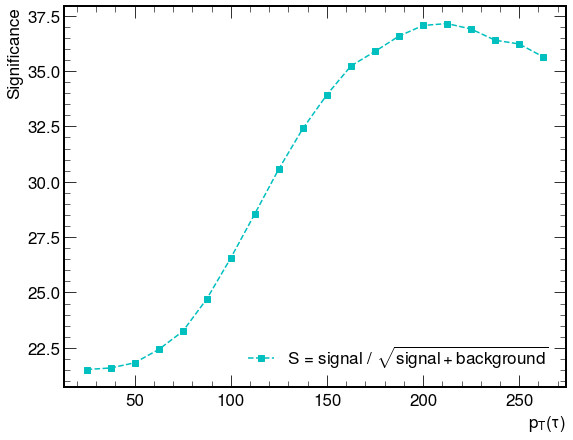

In [89]:
pt_min = 25
pt_max = 275
arr_pt = np.arange(pt_min, pt_max, 12.5)



sign1 = np.array([pt_tau_cut(Df_1000GeV_cut, val = i).shape[0] * w[1] \
          / ((pt_tau_cut(Df_bgw_cut, val = i).shape[0]* w[3]) +
             (pt_tau_cut(Df_bgz_cut, val = i).shape[0] * w[4]) +
            pt_tau_cut(Df_1000GeV_cut, val = i).shape[0] * w[1]) ** 0.5 \
         for i in arr_pt])

print(sign1[-9], arr_pt[-9], sep =', ')
#print(pt_tau_cut(Df_bgw_cut, val = i).shape[0])
#print(pt_tau_cut(Df_bgw_cut, val = i).shape[0]* w[3])
plt.figure(figsize=(9,7))
plt.plot(arr_pt, sign1,'cs--', label = r"S = signal / $\sqrt{signal + background}$")
plt.ylabel('Significance', fontsize= 17)
plt.xlabel(r'$p_T(\tau)$', fontsize= 17)
plt.legend(fontsize= 17)
plt.xticks(fontsize= 17)
plt.yticks(fontsize= 17);

In [90]:
#Applying cuts over the data 
opt = 150
Df_600GeV_cut = final_cuts(Df_600GeV, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_1000GeV_cut = final_cuts(Df_1000GeV, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_1600GeV_cut = final_cuts(Df_1600GeV, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)

In [91]:
#Efficiency
print(Df_1000GeV_cut.shape[0]/ Df_1000GeV.shape[0])
print(Df_bgw_cut.shape[0] / Df_bg_wj.shape[0])
print(Df_bgz_cut.shape[0] / Df_bg_zj.shape[0])

0.5863989447457131
0.12308446332298643
0.1797247822244666


51.890407994342794, 0.8


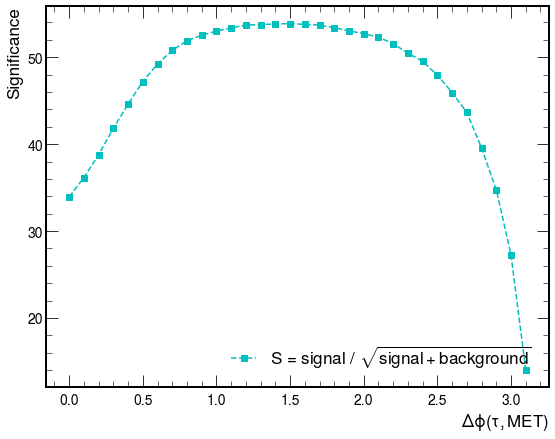

In [92]:
del_phi_min = 0
del_phi_max = np.pi
arr_dp = np.arange(del_phi_min, del_phi_max, 0.1)



#print(pt_tau_cut(Df_bgw_cut, val = 214).shape[0]* w[3])

sign2 = np.array([phi_tau_cut(Df_1000GeV_cut, val = i).shape[0] * w[1] \
          / ((phi_tau_cut(Df_bgw_cut, val = i).shape[0]* w[3]) + 
             (phi_tau_cut(Df_bgz_cut, val = i).shape[0] * w[4])+ 
            phi_tau_cut(Df_1000GeV_cut, val = i).shape[0] * w[1]) ** 0.5 \
         for i in arr_dp])

print(sign2[8], arr_dp[8], sep =', ')
plt.figure(figsize=(9,7))
plt.plot(arr_dp, sign2,'cs--', label = r"S = signal / $\sqrt{signal + background}$")
plt.ylabel('Significance', fontsize= 17)
plt.xlabel(r'$\Delta\phi(\tau,MET)$', fontsize= 17)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);
plt.legend(loc = 'lower right', fontsize= 17);

In [121]:
opt = 150
odp = 1.
#odp = 1.5
Df_600GeV_cut = final_cuts(Df_600GeV, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_1000GeV_cut = final_cuts(Df_1000GeV, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_1600GeV_cut = final_cuts(Df_1600GeV, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)

In [122]:
#Eficiencies
print(Df_1000GeV_cut.shape[0]/ Df_1000GeV.shape[0])
print(Df_bgw_cut.shape[0] / Df_bg_wj.shape[0])
print(Df_bgz_cut.shape[0] / Df_bg_zj.shape[0])

0.5651472959108896
0.024995915700049012
0.059891427850018934


59.58835624149496, 150.0


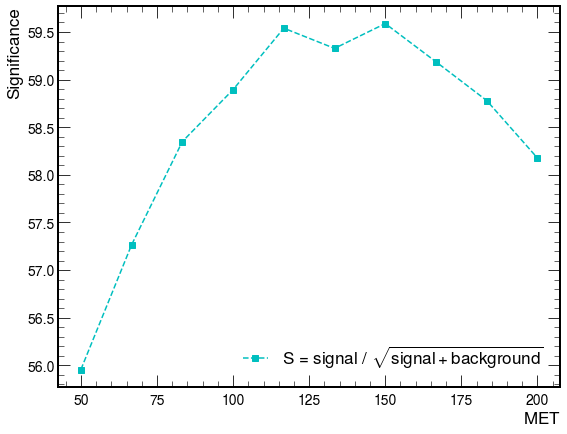

In [123]:
met_min = 50
met_max = 200
arr_dmet = np.linspace(met_min, met_max, 10)


#print(pt_tau_cut(Df_bgw_cut, val = 214).shape[0]* w[3])

sign3 = np.array([et_met_cut(Df_1000GeV_cut, val = i).shape[0] * w[1] \
          / (et_met_cut(Df_bgw_cut, val = i).shape[0]* w[3] + 
             et_met_cut(Df_bgz_cut, val = i).shape[0] * w[4] + 
            et_met_cut(Df_1000GeV_cut, val = i).shape[0] * w[1]) ** 0.5 \
         for i in arr_dmet])
print(sign3[6], arr_dmet[6], sep =', ')
plt.figure(figsize=(9,7))
plt.plot(arr_dmet, sign3,'cs--', label = r"S = signal / $\sqrt{signal + background}$")
plt.ylabel('Significance', fontsize= 17)
plt.xlabel(r'$MET$', fontsize= 17)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);
plt.legend(loc = 'lower right', fontsize= 17);

In [124]:
opt = 150
odp = 1.0
omet = 120
Df_600GeV_cut = final_cuts(Df_600GeV, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_1000GeV_cut = final_cuts(Df_1000GeV, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_1600GeV_cut = final_cuts(Df_1600GeV, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)

In [125]:
#Eficiencies
print(Df_1000GeV_cut.shape[0]/ Df_1000GeV.shape[0])
print(Df_bgw_cut.shape[0] / Df_bg_wj.shape[0])
print(Df_bgz_cut.shape[0] / Df_bg_zj.shape[0])

0.5263080756265572
0.0113380166639438
0.011564196439843454


In [111]:
df = pd.DataFrame(ex_ev_s, columns = ["expected_events"])
df['First_Selection'] = np.array([Df_600GeV.shape[0], Df_1000GeV.shape[0],
                                 Df_1600GeV.shape[0], Df_bg_wj.shape[0], Df_bg_zj.shape[0]]) * w 
df['Second_Selection'] = np.array([Df_600GeV_cut.shape[0], Df_1000GeV_cut.shape[0],
                                 Df_1600GeV_cut.shape[0], Df_bgw_cut.shape[0], Df_bgz_cut.shape[0]]) * w 
df

,expected_events,First_Selection,Second_Selection
S600GeV,15.750000,101556.000000,31783.500000
S1000GeV,1.350000,9211.050000,4847.850000
S1600GeV,0.090000,614.340000,363.870000
Bg_WJ,4.488545,137371.907450,1557.524976
Bg_ZJ,0.425516,16852.559442,194.886308


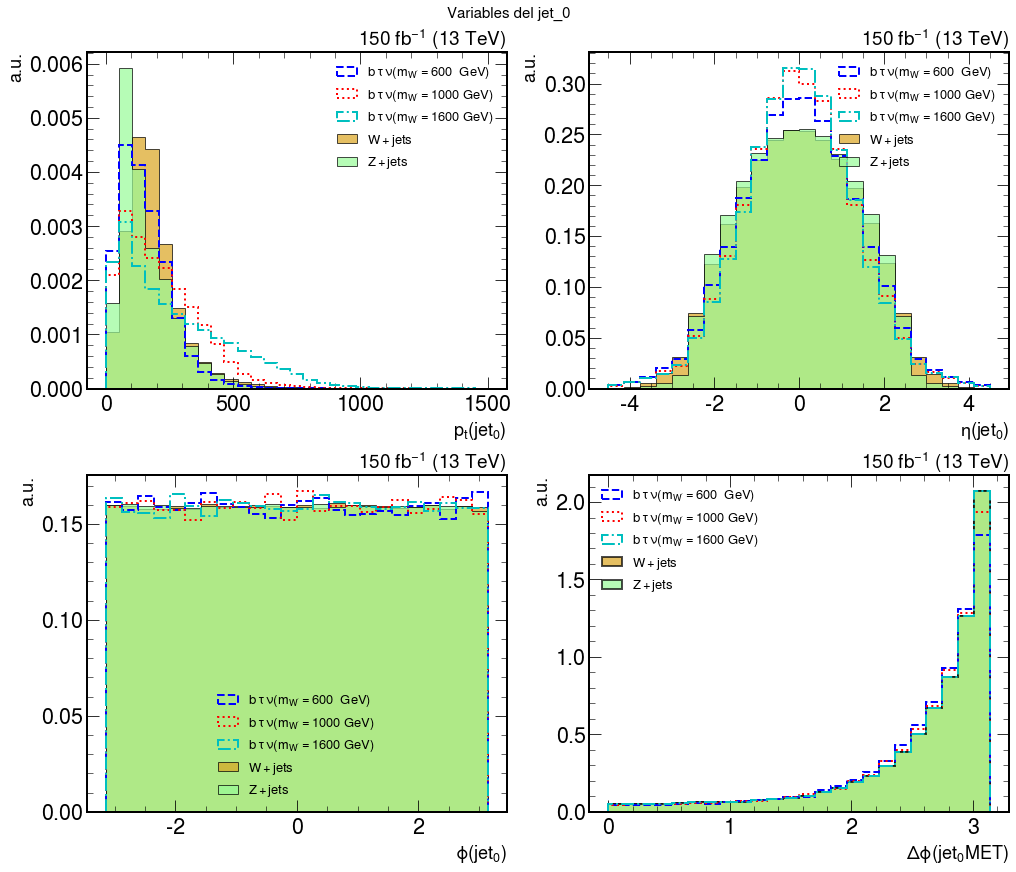

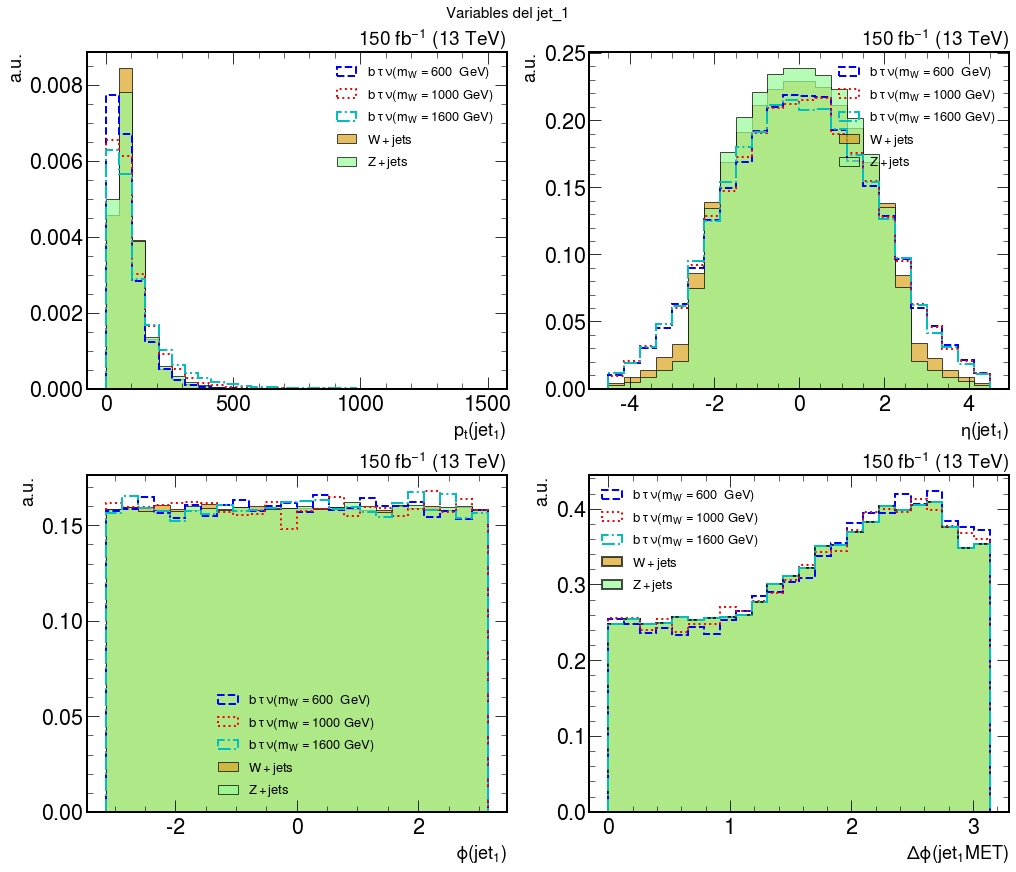

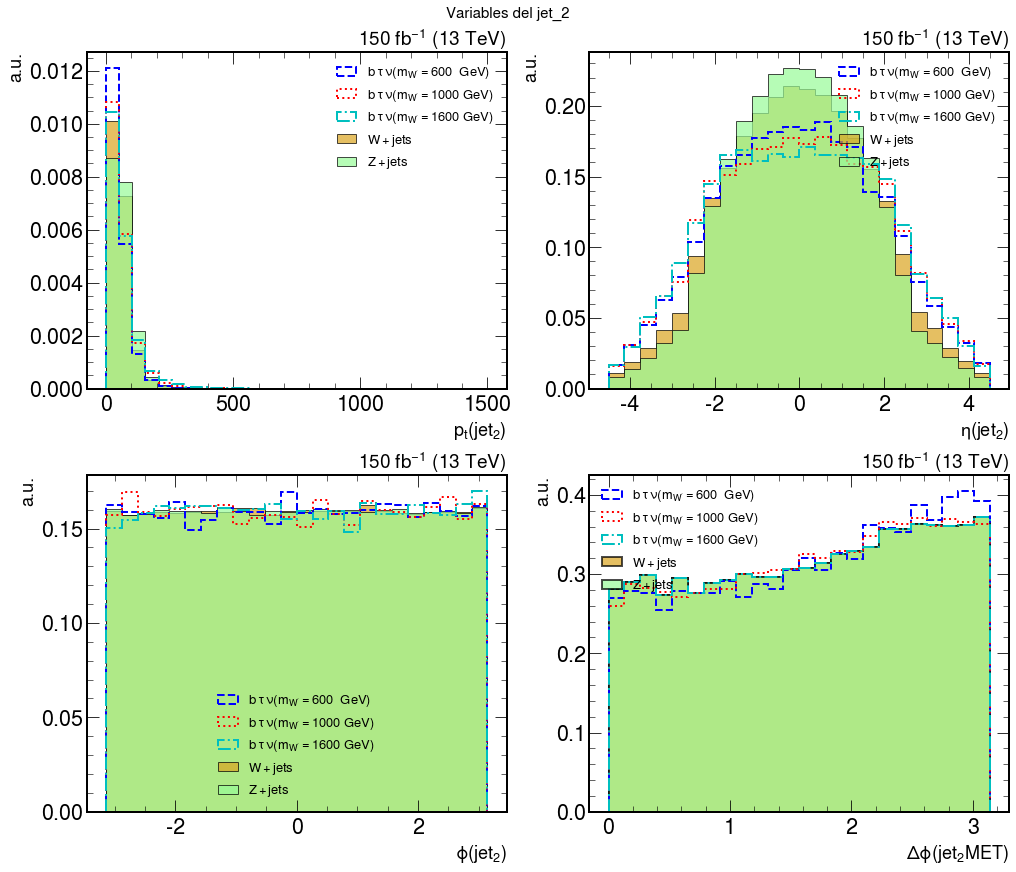

In [128]:

#PT, eta, phi and delta phi with Met for the i = 3 first jets

labs1 = [r"$b\,\tau\,\nu$($m_{W'} = 600$  GeV)",
        r"$b\,\tau\,\nu$($m_{W'} = 1000$ GeV)", 
        r"$b\,\tau\,\nu$($m_{W'} = 1600$ GeV)",
         "$W+$jets",
         "$Z+$jets"]
colo1 = ['b', 'r', 'c', 'goldenrod', 'palegreen']
colo2 = ['g', 'k', 'm']
lineas1 = ["--", ":", "-."]
w2 = df.Second_Selection
w1 = df.First_Selection

for j in range(3):
  plot_pt_eta_phi1(labels= labs1 ,colors=colo1 , lines= lineas1, df1 =df_600Gev,df2 =df_1000Gev,df3 =df_1600Gev ,
                   bg1 = df_bg_wj, bg2 = df_bg_zj, i = j)

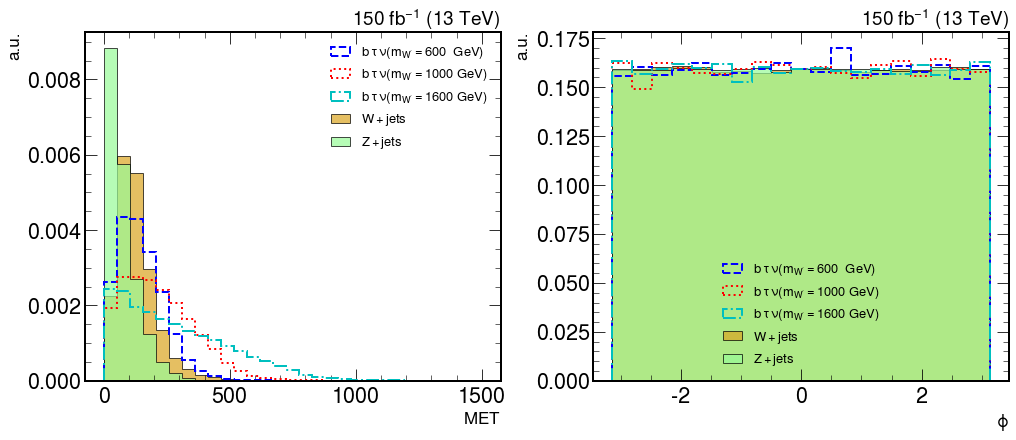

In [138]:
plot_Met_ET_Phi1(df1 =df_600Gev,df2 =df_1000Gev,df3 =df_1600Gev ,
                 bg1 = df_bg_wj, bg2 = df_bg_zj, labels = labs1,
                 colors = colo1, lines = lineas1)

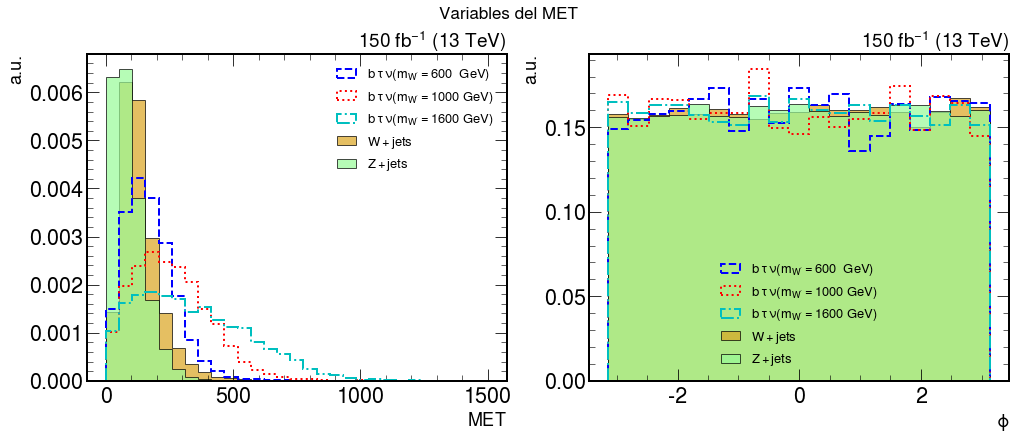

In [141]:
plot_Met_ET_Phi2(df1 = Df_600GeV,df2 = Df_1000GeV,df3 = Df_1600GeV ,
                 bg1 = Df_bg_wj, bg2 = Df_bg_zj, labels = labs1,
                 colors = colo1, lines = lineas1)

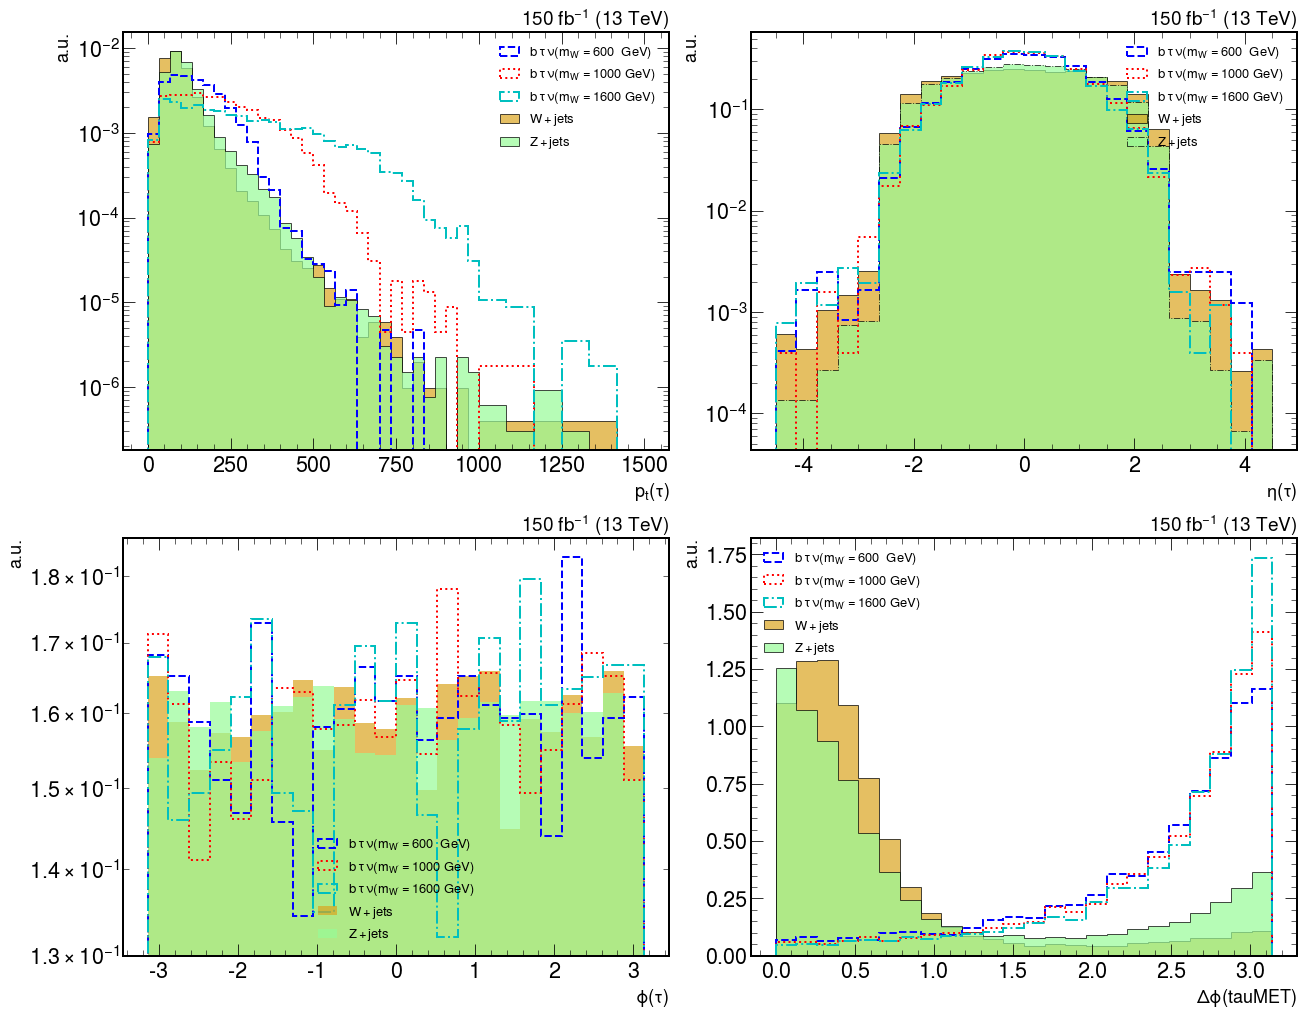

In [129]:
#Pt Eta phi and delta phi with met for the tau
plot_pt_eta_phi2(labels= labs1, colors= colo1,
                 lines= lineas1, obj = "tau", df1 = Df_600GeV, 
                 df2 = Df_1000GeV, df3 = Df_1600GeV,
                 bg1 = Df_bg_wj, bg2 = Df_bg_zj )

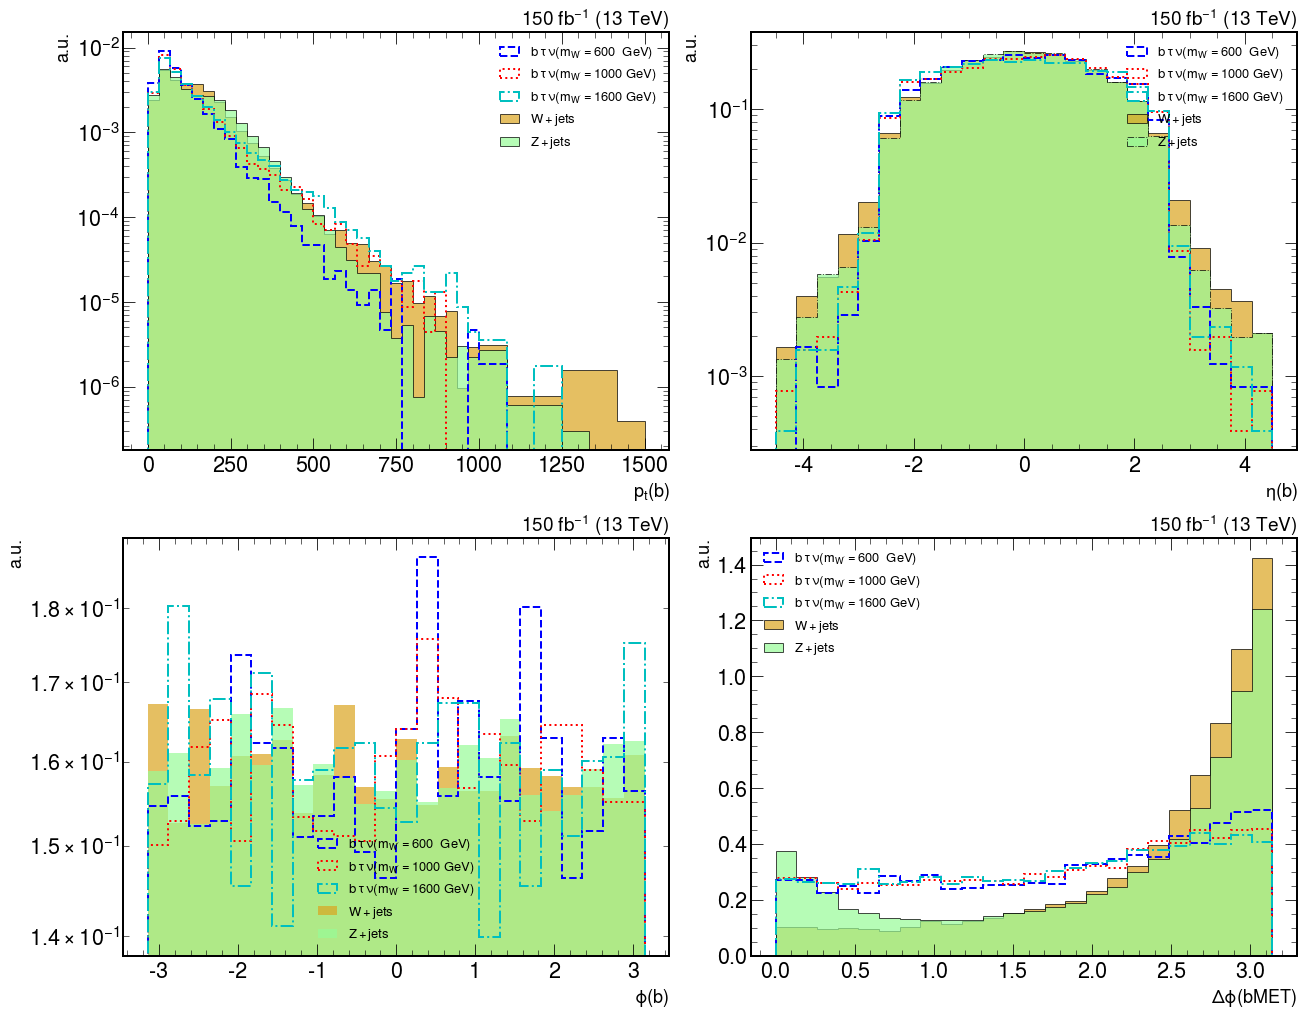

In [130]:
#Pt Eta phi and delta phi with met for the tau
plot_pt_eta_phi2(labels= labs1, colors= colo1,
                 lines= lineas1, obj = "b", df1 = Df_600GeV, 
                 df2 = Df_1000GeV, df3 = Df_1600GeV,
                 bg1 = Df_bg_wj, bg2 = Df_bg_zj )

In [28]:
Df_600GeV_cut.to_csv('Signal_600GeV.csv')
Df_1000GeV_cut.to_csv('Signal_1000GeV.csv')
Df_1600GeV_cut.to_csv('Signal_1600GeV.csv'), 
Df_bgw_cut.to_csv('Background_W_plus_Jets.csv')
Df_bgz_cut.to_csv('Background_Z_plus_Jets.csv') 

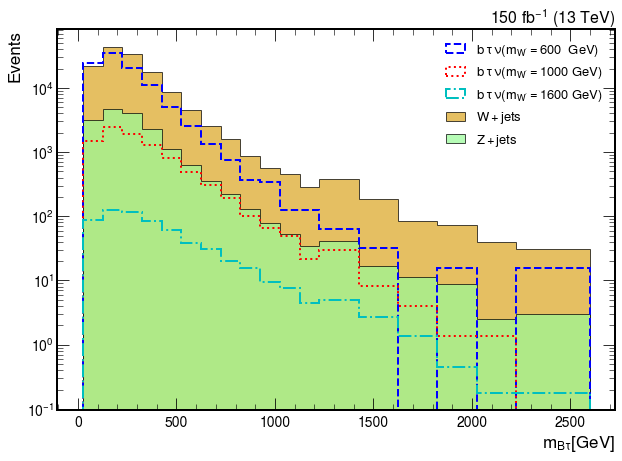

In [115]:
m_tau_b1 = generate_ploteable_invariant_masses(Df_600GeV,Df_1000GeV, Df_1600GeV)
m_inv_BgZ = invariant_mass(Df_bg_zj.tau_pT, Df_bg_zj.tau_eta, Df_bg_zj.b_pT, Df_bg_zj.b_eta, Df_bg_zj.Delta_phi_Tau_B)
m_inv_BgW = invariant_mass(Df_bg_wj.tau_pT, Df_bg_wj.tau_eta, Df_bg_wj.b_pT, Df_bg_wj.b_eta, Df_bg_wj.Delta_phi_Tau_B)

#Invariant Mass between tau, b
plot_mass1(labels= labs1, colors= colo1, lines = lineas1, 
           mass_type= r'$m_{B \tau}[GeV]$', m1= m_tau_b1[0], 
           m2 =m_tau_b1[1], m3 =m_tau_b1[2], m_bg1 = m_inv_BgW,
           Weights = df["expected_events"], m_bg2 = m_inv_BgZ,
           nbins = [[i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                   [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                   [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600]],
           bins_bg = [[i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                     [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600]])

#plt.ylim(0.5,2e3)
#plt.xlim(-100,2e3);

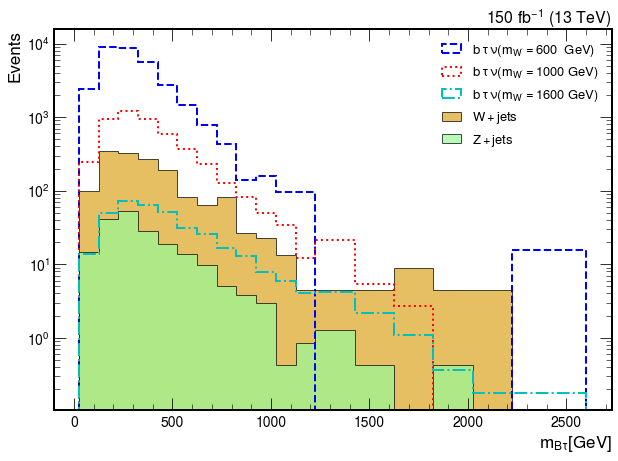

In [116]:
m_tau_b1 = generate_ploteable_invariant_masses(Df_600GeV_cut,Df_1000GeV_cut, Df_1600GeV_cut)
m_inv_BgZ = invariant_mass(Df_bgz_cut.tau_pT, Df_bgz_cut.tau_eta, Df_bgz_cut.b_pT,
                           Df_bgz_cut.b_eta, Df_bgz_cut.Delta_phi_Tau_B)
m_inv_BgW = invariant_mass(Df_bgw_cut.tau_pT, Df_bgw_cut.tau_eta, Df_bgw_cut.b_pT,
                           Df_bgw_cut.b_eta, Df_bgw_cut.Delta_phi_Tau_B)

#Invariant Mass between tau, b with cuts
plot_mass1(labels= labs1, colors= colo1, lines = lineas1, 
           mass_type= r'$m_{B \tau}[GeV]$', m1= m_tau_b1[0], 
           m2 =m_tau_b1[1], m3 =m_tau_b1[2], m_bg1 = m_inv_BgW,
           Weights = df["expected_events"], m_bg2 = m_inv_BgZ,
           nbins = [[i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                   [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                   [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600]],
           bins_bg = [[i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                     [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600]])

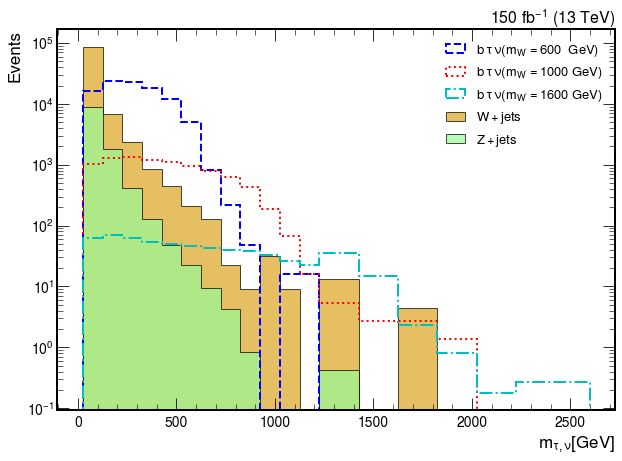

In [117]:
#Transverse mass of tau without cuts
m_trvs_tau_nu1 = generate_ploteable_tr_tau_nu_masses(Df_600GeV,Df_1000GeV, Df_1600GeV)
m_trvs_BgZ = transverse_mass(Df_bg_zj.tau_pT, Df_bg_zj.met_Met, Df_bg_zj.Delta_phi_Tau_Met)
m_trvs_BgW = transverse_mass(Df_bg_wj.tau_pT, Df_bg_wj.met_Met, Df_bg_wj.Delta_phi_Tau_Met)


plot_mass1(labels= labs1, colors= colo1, lines = lineas1, 
           mass_type= r'$m_{\tau, \nu}[GeV]$', m1 = m_trvs_tau_nu1[0], m2 = m_trvs_tau_nu1[1], 
           m3 = m_trvs_tau_nu1[2], m_bg1 = m_trvs_BgW, m_bg2 = m_trvs_BgZ,
           Weights = df["expected_events"], 
           nbins = [[i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                   [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                   [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600]],
           bins_bg = [[i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                     [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600]])

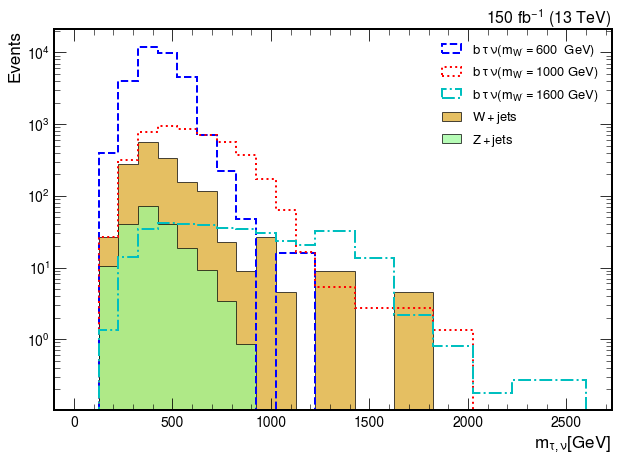

In [118]:
#Transverse mass of tau with cuts
m_trvs_tau_nu2 = generate_ploteable_tr_tau_nu_masses(Df_600GeV_cut,Df_1000GeV_cut, Df_1600GeV_cut)
m_trvs_BgW_cut = transverse_mass(Df_bgw_cut .tau_pT, Df_bgw_cut.met_Met, Df_bgw_cut.Delta_phi_Tau_Met)
m_trvs_BgZ_cut = transverse_mass(Df_bgz_cut .tau_pT, Df_bgz_cut.met_Met, Df_bgz_cut.Delta_phi_Tau_Met)

plot_mass1(labels= labs1, colors= colo1, lines = lineas1, 
           mass_type= r'$m_{\tau, \nu}[GeV]$', m1 = m_trvs_tau_nu2[0], m2 = m_trvs_tau_nu2[1], 
           m3 = m_trvs_tau_nu2[2], m_bg1 = m_trvs_BgW_cut,
           Weights = df["expected_events"], m_bg2 = m_trvs_BgZ_cut,
           nbins = [[i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                   [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                   [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600]],
           bins_bg = [[i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                     [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600]])


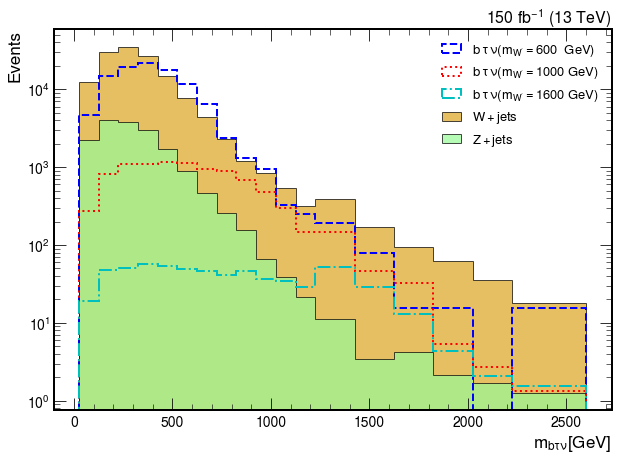

In [119]:
#Total mass between b tau nu without cuts
m_T1 = generate_ploteable_total_masses(Df_600GeV, Df_1000GeV, Df_1600GeV)
m_T_bg_Z1 = Df_bg_zj.apply(m_Tot, axis = 1)
m_T_bg_W1 = Df_bg_wj.apply(m_Tot, axis = 1)
plot_mass1(labels= labs1, colors= colo1, lines = lineas1,
           mass_type = r'$m_{b \tau \nu}[GeV]$', m1 = m_T1[0],
           m2 = m_T1[1], m3 = m_T1[2], m_bg1 = m_T_bg_W1, m_bg2 = m_T_bg_Z1 ,
           Weights = df["expected_events"], 
           nbins = [[i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                   [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                   [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600]],
           bins_bg = [[i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                     [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600]])


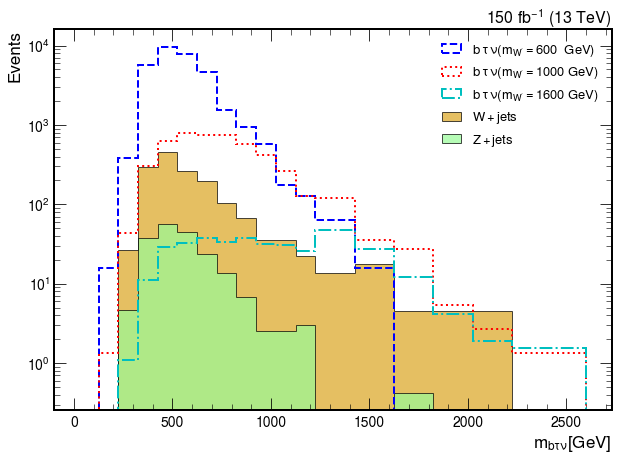

In [120]:
#Total mass without b tau nu with cuts
m_T1 = generate_ploteable_total_masses(Df_600GeV_cut, Df_1000GeV_cut, Df_1600GeV_cut)
m_T_bg_Z2 = Df_bgz_cut.apply(m_Tot, axis = 1)
m_T_bg_W2 = Df_bgw_cut.apply(m_Tot, axis = 1)

plot_mass1(labels= labs1, colors= colo1, lines = lineas1,
           mass_type = r'$m_{b \tau \nu}[GeV]$', m1 = m_T1[0],
           m2 = m_T1[1], m3 = m_T1[2], m_bg1 = m_T_bg_W2, m_bg2 = m_T_bg_Z2 ,
           Weights = df["expected_events"], 
           nbins = [[i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                   [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                   [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600]],
           bins_bg = [[i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600],
                     [i for i in range(25,1225,100)] + [i for i in range(1225, 2226,200)]+[2600]])